# Инициализация

In [0]:
#@markdown - **Монтирование GoogleDrive** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **Размонтирование**
# !fusermount -u GoogleDrive

# Область кодов

In [0]:
#@title Модель гауссовых смесей { display-mode: "both" }
# В программе реализована оценка параметров модели гауссовых смесей с помощью ЕМ-алгоритм
# Модель гауссовых смесей для кластеризации стохастических данных
# coding: utf-8
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
#@markdown - **Привязка данных**
class Bunch(dict):  
    def __init__(self,*args,**kwds):  
        super(Bunch,self).__init__(*args,**kwds)  
        self.__dict__ = self

In [0]:
#@markdown - **Класс модели гауссовых смесей**
class GaussianMM: 
    def __init__(self):
        self.mu = None
        self.sigma = None
        self.alpha = None
        self.f_dim = None
        self.num_mixed = None

    # Инициализация
    def init_fn(self, f_dim=3, num_mixed=4):
        self.f_dim = f_dim
        self.num_mixed = num_mixed
        self.mu = np.random.randn(num_mixed, f_dim) + 10
        self.sigma = np.zeros((num_mixed, f_dim, f_dim))
        for i in range(num_mixed):
            self.sigma[i, :, :] = np.diag(np.random.randint(10, 25, size=(3, )))
        self.alpha = [1. / num_mixed] * int(num_mixed)
        return 'Initialization completed !'

    # e-step
    def e_step(self, X):
        N, _ = X.shape
        expec = np.zeros((N, self.num_mixed))
        for i in range(N):  
            denom = 0  
            # numer = 0
            F_list = []
            S_list = []
            for j in range(self.num_mixed):
                sig_inv = np.linalg.inv(self.sigma[j, :, :])
                expo_1 = np.matmul(-(X[i, :] - self.mu[j, :]), sig_inv)
                expo_2 = np.matmul(expo_1, ((X[i, :] - self.mu[j, :])).reshape(-1, 1))
                first_half = self.alpha[j] * np.exp(expo_2)
                # first_half = alpha_[j] * np.exp(-(X[i, :] - mu[j, :]) * sig_inv * ((X[i, :] - mu[j, :])).reshape(-1, 1))
                sec_half = np.sqrt(np.linalg.det(np.mat(self.sigma[j, :, :])))
                F_list.append(first_half[0])
                S_list.append(sec_half)
                denom += first_half[0] / sec_half      # знаменатель
            for j in range(self.num_mixed):  
                numer = F_list[j] / S_list[j]        # числитель
                expec[i, j]= numer / denom      # ожидание
        return expec

    # m-step
    def m_step(self, X, expec):  
        N, c = X.shape
        lemda = 1e-15
        for j in range(self.num_mixed):  
            denom = 0   # знаменатель  
            numer = 0   # числитель 
            sig = 0 
            for i in range(N):  
                numer += expec[i, j] * X[i, :]  
                denom += expec[i, j]
            self.mu[j, :] = numer / denom    # среднее значение  
            for i in range(N):
                x_tran = (X[i, :] - self.mu[j, :]).reshape(-1, 1)
                x_nor = (X[i, :] - self.mu[j, :]).reshape(1, -1)
                sig += expec[i, j] * np.matmul(x_tran, x_nor)
            self.alpha[j] = denom / N        # коэффициенты модели смесей
            self.sigma[j, :, :] = sig / denom + np.diag(np.array([lemda] * c))
        return self.mu, self.sigma, self.alpha

    # Обучение
    def fit(self, X, err_mu=5, err_alpha=0.01, max_iter=100):
        iter_num = 0
        while True:
            if iter_num == max_iter: break
            iter_num += 1
            mu_prev = self.mu.copy()
            # print(mu_prev)
            alpha_prev = self.alpha.copy()
            # print(alpha_prev)
            expec = self.e_step(X)
            self.mu, self.sigma, self.alpha = self.m_step(X, expec)
            print(u"Количество итераций:", iter_num)
            print(u"Оценка средних значений:\n", self.mu)
            print(u"Оценка коэффициенты модели смесей:\n", self.alpha, '\n')
            err = abs(mu_prev - self.mu).sum()      # ошибки
            err_a = abs(np.array(alpha_prev) - np.array(self.alpha)).sum()
            if (err < err_mu) and (err_a < err_alpha):
                print(u"\nКонечные ошибки:", [err, err_a])  
                break
        print('Обучение завершено !')
    
    # Прогноз
    def predict(self, X):
        expec = self.e_step(X)
        return np.argmax(expec, axis=1)


In [0]:
#@markdown - **Генератор стохастических данных**
def generate_random(sigma, N, mu1=[15., 25., 10], mu2=[30., 40., 30], mu3=[25., 10., 20], mu4=[40., 30., 40]):  
    c = sigma.shape[-1]
    X = np.zeros((N, c))
    target = np.zeros((N,1))
    for i in range(N):  
        if np.random.random(1) < 0.25:
            X[i, :]  = np.random.multivariate_normal(mu1, sigma[0, :, :], 1)     # первая гауссовская модель  
            target[i] = 0
        elif 0.25 <= np.random.random(1) < 0.5:  
            X[i, :] = np.random.multivariate_normal(mu2, sigma[1, :, :], 1)      # вторая гауссовская модель
            target[i] = 1
        elif 0.5 <= np.random.random(1) < 0.75:  
            X[i, :] = np.random.multivariate_normal(mu3, sigma[2, :, :], 1)      # третья гауссовская модель
            target[i] = 2
        else:  
            X[i, :] = np.random.multivariate_normal(mu4, sigma[3, :, :], 1)      # четвертая гауссовская модель
            target[i] = 3
    return X, target

In [0]:
#@markdown - **Стохастические данные**
k, N = 4, 400
sigma = np.zeros((k, 3, 3))
for i in range(k):
	sigma[i, :, :] = np.diag(np.random.randint(10, 25, size=(3, )))
sample, target = generate_random(sigma, N)
feature_names = ['x_label', 'y_label', 'z_label']
target_names = ['gaussian1', 'gaussian2', 'gaussian3', 'gaussian4']
data = Bunch(sample=sample, feature_names=feature_names, target=target, target_names=target_names)


In [0]:
#@markdown - **Итеративное обучение до выполнения условия сходимости**
# Инициализация параметров модели
model = GaussianMM()
err_mu = 1e-4 #@param {type: "number"}
err_alpha = 1e-4 #@param {type: "number"}
# -------------Две категории----------------
model.init_fn(f_dim=3, num_mixed=2)
# print('mu:\n', model.mu)
# print('sigma:\n', model.sigma)
# print('alpha:\n', model.alpha)
# Обучение модели
model.fit(data.sample, err_mu=err_mu, err_alpha=err_alpha, max_iter=100)
# Прогноз
tar2 = model.predict(data.sample)


Количество итераций: 1
Оценка средних значений:
 [[30.35809504 28.59574004 28.3186317 ]
 [19.87849699 18.39539874  9.86702676]]
Оценка коэффициенты модели смесей:
 [0.9542858590901746, 0.04571414090982648] 

Количество итераций: 2
Оценка средних значений:
 [[31.07137748 29.30640616 29.54361756]
 [19.84321804 18.22309952 10.06501252]]
Оценка коэффициенты модели смесей:
 [0.893807327034336, 0.1061926729656637] 

Количество итераций: 3
Оценка средних значений:
 [[31.69754776 30.08565549 30.61995935]
 [20.05848813 17.56529572 10.49213153]]
Оценка коэффициенты модели смесей:
 [0.8437572625142997, 0.15624273748570044] 

Количество итераций: 4
Оценка средних значений:
 [[32.16023874 30.68209674 31.39050921]
 [20.13991689 17.2314457  10.75930951]]
Оценка коэффициенты модели смесей:
 [0.810220595914829, 0.18977940408517088] 

Количество итераций: 5
Оценка средних значений:
 [[32.49101156 31.06138618 31.85055125]
 [20.12051764 17.17552661 11.12832386]]
Оценка коэффициенты модели смесей:
 [0.7888

In [0]:
# -------------Три категории----------------
model.init_fn(f_dim=3, num_mixed=3)
model.fit(data.sample, err_mu=err_mu, err_alpha=err_alpha, max_iter=100)
tar3 = model.predict(data.sample)

Количество итераций: 1
Оценка средних значений:
 [[32.10505257 17.52791162 27.53012283]
 [18.87459266 15.90106234 10.66090796]
 [29.23211635 31.49840659 27.53286237]]
Оценка коэффициенты модели смесей:
 [0.2373716096418423, 0.0033831086706209786, 0.7592452816875371] 

Количество итераций: 2
Оценка средних значений:
 [[33.26663488 18.12229101 29.13380664]
 [18.8135415  19.75724554  6.21958111]
 [28.97960113 31.72812207 27.39798459]]
Оценка коэффициенты модели смесей:
 [0.24969439909351226, 0.016822665814363275, 0.7334829350921251] 

Количество итераций: 3
Оценка средних значений:
 [[33.93802219 18.82463349 30.16908378]
 [17.93096875 21.50530906  4.74642437]
 [28.9986429  32.08723464 27.73470711]]
Оценка коэффициенты модели смесей:
 [0.26686066973490763, 0.03955119567768258, 0.6935881345874099] 

Количество итераций: 4
Оценка средних значений:
 [[34.28251791 19.31711842 30.77990669]
 [17.2202711  22.02095782  4.38273266]
 [28.98441638 32.32017035 27.84143754]]
Оценка коэффициенты модели 

In [0]:
# -------------Четыре категории----------------
model.init_fn(f_dim=3, num_mixed=4)
model.fit(data.sample, err_mu=err_mu, err_alpha=err_alpha, max_iter=100)
tar4 = model.predict(data.sample)

Количество итераций: 1
Оценка средних значений:
 [[36.97326049 25.01160276 35.2975184 ]
 [27.97287566 15.40847888 31.95744779]
 [18.26120763 28.46953415 13.360644  ]
 [29.74737524 33.28383265 27.92364081]]
Оценка коэффициенты модели смесей:
 [0.4258193665186193, 0.02319928612943993, 0.25283461604170254, 0.298146731310239] 

Количество итераций: 2
Оценка средних значений:
 [[37.28257026 24.94006902 35.44679586]
 [26.16712493 12.97343184 28.68836745]
 [15.95364181 26.57859921 10.48636225]
 [32.03530131 36.82369486 30.7138387 ]]
Оценка коэффициенты модели смесей:
 [0.4181127541372037, 0.047443486019170325, 0.25319622150587223, 0.28124753833775423] 

Количество итераций: 3
Оценка средних значений:
 [[37.44125034 25.11021025 35.55019555]
 [26.25379246 12.31220965 28.25482587]
 [15.03800355 24.861246    8.96747437]
 [33.24550056 38.81453124 32.54154912]]
Оценка коэффициенты модели смесей:
 [0.40634892884969515, 0.05816659878246199, 0.2561980861852544, 0.27928638618258816] 

Количество итерац

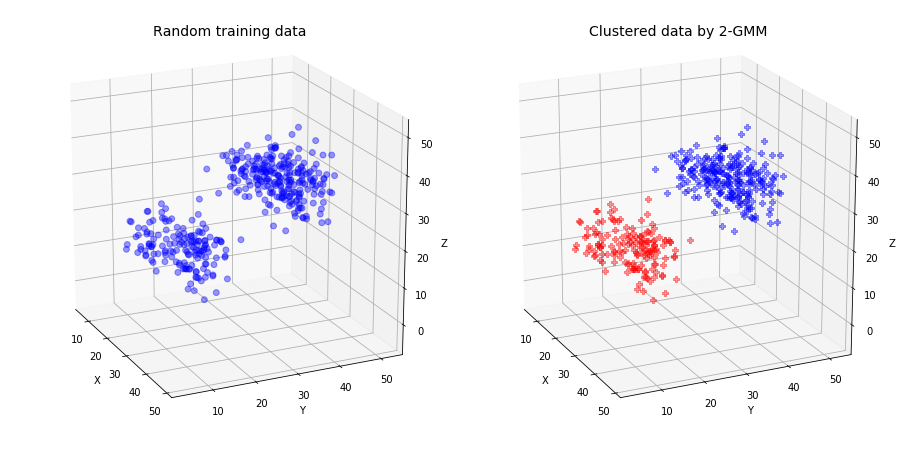

In [0]:
#@markdown - **Представление распределения обучающих данных и результата кластеризации**
#@markdown - **Обучающие данные и две категории**
titles = ['Random training data', 'Clustered data by 2-GMM']
DATA = [data.sample, data.sample]
color=['b','r','g','y']
fig = plt.figure(1, figsize=(16, 8))
fig.subplots_adjust(wspace=.01, hspace=.02)
for i, title, data_n in zip([1, 2], titles, DATA):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    if title == 'Random training data':
        ax.scatter(data_n[:,0], data_n[:,1], data_n[:,2], c='b', s=35, alpha=0.4, marker='o')
    else:
        for j in range(N):
            ax.scatter(data_n[j, 0], data_n[j, 1], data_n[j, 2], c=color[tar2[j]], s=35, alpha=0.4, marker='P')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=20., azim=-25)
    ax.set_title(title, fontsize=14)

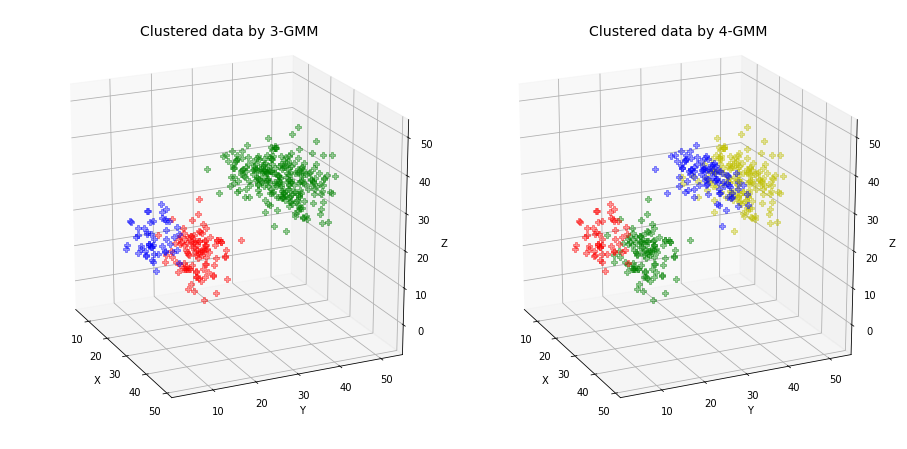

In [0]:
#@markdown - **Три категории и четыре категории**
titles = ['Clustered data by 3-GMM', 'Clustered data by 4-GMM']
TAR = [tar3, tar4]
fig = plt.figure(2, figsize=(16, 8))
fig.subplots_adjust(wspace=.01, hspace=.02)
for i, title, data_n, tar in zip([1, 2], titles, DATA, TAR):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    for j in range(N):
        ax.scatter(data_n[j, 0], data_n[j, 1], data_n[j, 2], c=color[tar[j]], s=35, alpha=0.4, marker='P')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=20., azim=-25)
    ax.set_title(title, fontsize=14)
plt.show()